In [ ]:
# Install required libraries
!pip install pandas matplotlib seaborn scikit-learn xgboost

#**Import** **Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter

#**Load the Dataset**

In [2]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Load the CSV
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#**Data Preprocessing**

**i. Drop Customer ID**

In [3]:
df = df.drop(columns=['customerID'])

**ii. Handling Missing Values**

In [4]:
# Check for missing values in each column and display the count
missing_values = df.isnull().sum()

# Display the number of missing values for each column
print(missing_values)


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


**iii. Handling Categorical Data**

In [5]:
# Replace "No internet service" or "No phone service" with "No" in relevant columns
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

In [6]:
# Convert 'TotalCharges' to numeric (it contains spaces which become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

# Binary columns to label encode ('Yes'/'No')
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churn']

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])  # Yes=1, No=0 or Female=1, Male=0

# One-hot encode multi-class categorical variables
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)


**iv. Handling Outliers**

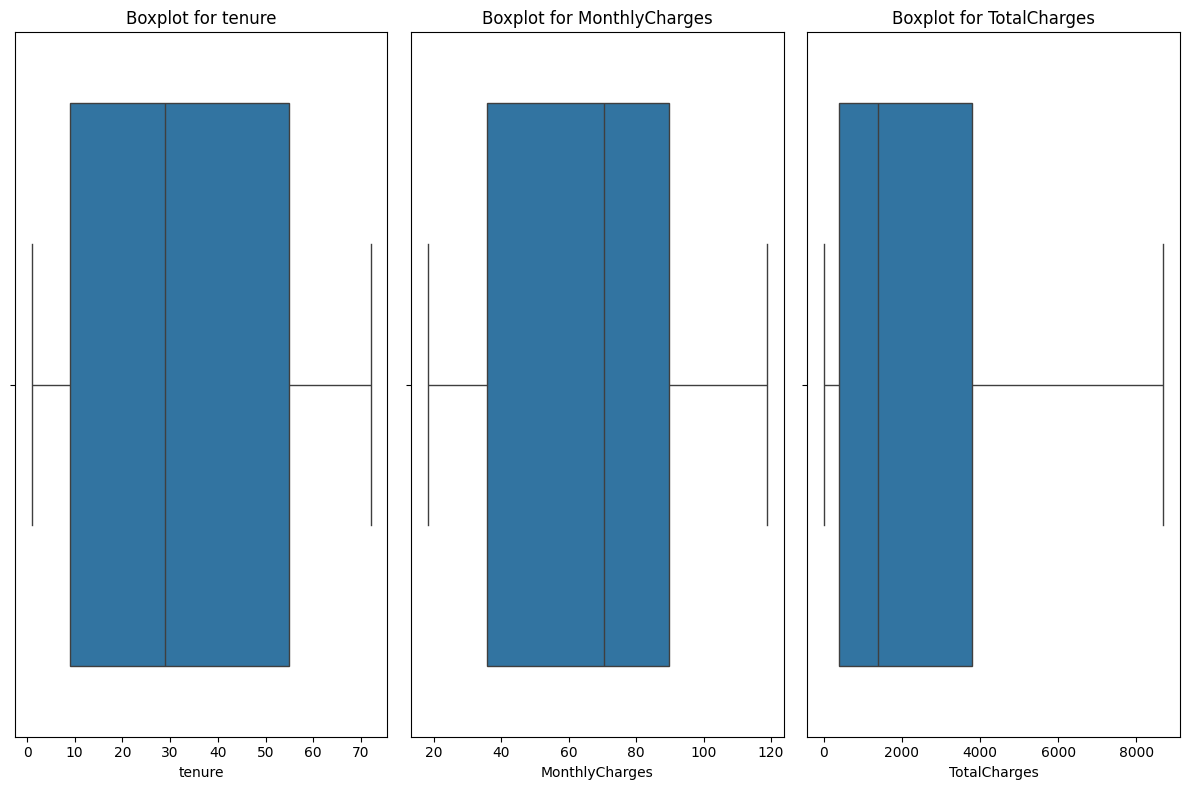

In [7]:
# Specify the columns
columns_to_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a boxplot for each specified column
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)  # Arrange boxplots in a row (1 row and 3 columns)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
plt.tight_layout()
plt.show()


In [8]:
def find_outliers(df, column):
    # Ensure the column is numeric (convert if necessary)
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Coerce invalid values to NaN

    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

# Find the number of outliers for each numeric column in columns_to_plot
outliers_count = {col: find_outliers(df, col) for col in columns_to_plot}

# Display the result in a table-like format
outliers_df = pd.DataFrame(list(outliers_count.items()), columns=["Column", "Number of Outliers"])
print(outliers_df)


           Column  Number of Outliers
0          tenure                   0
1  MonthlyCharges                   0
2    TotalCharges                   0


**v. Feature Scaling**

In [9]:
# Initialize the scaler
scaler = StandardScaler()

# Define the columns to scale
columns_to_scale = ['tenure', 'MonthlyCharges']

# Fit and transform the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Display the scaled columns
print(df[columns_to_scale].head())


     tenure  MonthlyCharges
0 -1.280248       -1.161694
1  0.064303       -0.260878
2 -1.239504       -0.363923
3  0.512486       -0.747850
4 -1.239504        0.196178


**vi. Feature Engineering**

In [10]:
# a. Average Charges Per Month

# Avoid division by zero and handle missing/infinite values safely
df['AvgChargesPerMonth'] = df['TotalCharges'] / df['tenure']
df['AvgChargesPerMonth'] = df['AvgChargesPerMonth'].replace([np.inf, -np.inf], 0)
df['AvgChargesPerMonth'] = df['AvgChargesPerMonth'].fillna(0)

df[['TotalCharges', 'tenure', 'AvgChargesPerMonth']].head()

,TotalCharges,tenure,AvgChargesPerMonth
0,29.85,-1.280248,-23.315794
1,1889.50,0.064303,29384.464964
2,108.15,-1.239504,-87.252638
3,1840.75,0.512486,3591.803618
4,151.65,-1.239504,-122.347319


In [11]:
# b. Number of Services Subscribed

# List of optional service columns from the Customer Churn dataset
service_cols = ['PhoneService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace 'No internet service' and 'No phone service' with 'No' for consistency
df[service_cols] = df[service_cols].replace({'No internet service': 'No', 'No phone service': 'No'})

# Create the new feature: number of services subscribed
df['num_services_subscribed'] = df[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

In [12]:
# c. Streaming Flag

df['hasStreaming'] = ((df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')).astype(int)

In [13]:
# Updated list of engineered features
engineered_features = ['AvgChargesPerMonth', 'num_services_subscribed', 'hasStreaming']

# Check for NaN or inf in engineered features
import numpy as np

check_missing_inf = df[engineered_features].apply(
    lambda x: {
        'NaN Count': x.isna().sum(),
        'Inf Count': np.isinf(x).sum()
    }
).T

# Display the result
print("Missing or Infinite Values in Engineered Features:")
print(check_missing_inf)

Missing or Infinite Values in Engineered Features:
AvgChargesPerMonth         {'NaN Count': 0, 'Inf Count': 0}
num_services_subscribed    {'NaN Count': 0, 'Inf Count': 0}
hasStreaming               {'NaN Count': 0, 'Inf Count': 0}
dtype: object


#**Split the Dataset into Features and Target Variable**

In [14]:
# Define the target variable (Churn) and feature variables
target = 'Churn'
features = df.drop(columns=[target])  # Drop the target column from the features

# Check the shape of the resulting dataframes
print("Features shape:", features.shape)
print("Target shape:", df[target].shape)

Features shape: (7032, 26)
Target shape: (7032,)


#**Split the Data into Training and Testing Sets**

In [15]:
# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# Check the shapes of the train and test sets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (5625, 26)
Testing data shape: (1407, 26)


#**Train a Machine Learning Model**

**a. Logistic Regression Model**

In [16]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression model with more iterations
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7882018479033405
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



#**Hyperparameter Tuning**

In [17]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

# Re-check accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Best Parameters: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.7903340440653873
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



#**Cross Validation**

In [18]:
# Perform cross-validation with the best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.816      0.808      0.79111111 0.79555556 0.82222222]
Mean cross-validation score: 0.8065777777777777


#**Apply SMOTE**

In [19]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the scaled training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Print the class distribution before and after SMOTE
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({0: 4130, 1: 1495})
After SMOTE: Counter({1: 4130, 0: 4130})


#**Train the Model on the Resampled Data**

In [20]:
# Initialize the model
model_smote = LogisticRegression(max_iter=1000)

# Train on resampled (balanced) training data
model_smote.fit(X_train_resampled, y_train_resampled)

# Predict on the original (unchanged) test set
y_pred_smote = model_smote.predict(X_test_scaled)

# Evaluate the model
print("SMOTE-based Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))

SMOTE-based Logistic Regression Accuracy: 0.7377398720682303
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



#**Confusion Matrix**

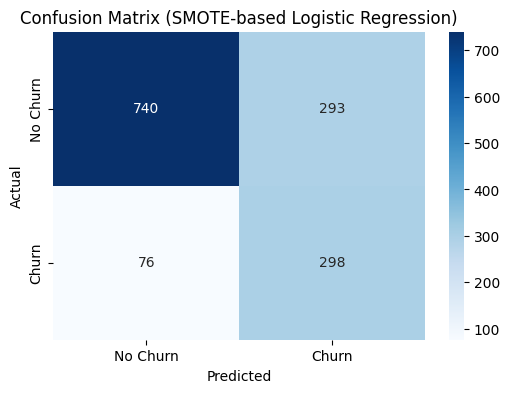

In [21]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_smote)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SMOTE-based Logistic Regression)')
plt.show()

#**Comparison**

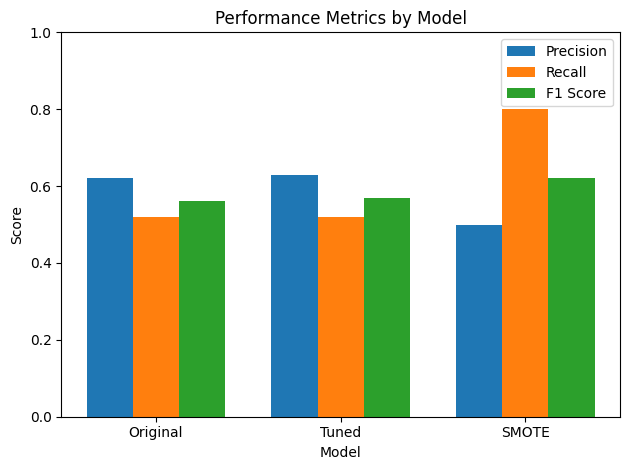

In [22]:
models = ['Original', 'Tuned', 'SMOTE']
precision = [0.62, 0.63, 0.50]
recall = [0.52, 0.52, 0.80]
f1 = [0.56, 0.57, 0.62]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1 Score')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [23]:
import joblib

joblib.dump(best_model, 'best_logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']